## 1. Beskriv data

### Analys av priser för bostadsrätter i Stockholm, Göteborg och Malmö.



##### Att priset på bostadsrätter skiljer sig åt runt om i landet är vida känt där det finns en uppsjö av olika faktorer som påverkar slutpriset. Allt från byggnadsår, skick, storlek och inte minst läget som vi i denna analysen kommer fokusera på.

I denna artikel jämför vi priser på bostadsrätter i Sveriges tre största städer Stockholm, Göteborg och Malmö. Dataunderlaget hämtas dynamiskt från webbplatsen Booli som tillhandahåller information kring objekt som finns till salu och de som sålts. Booli var den första sajten i Sverige att publicera slutpriser offentligt där dess data hämtas in regelbundet från mäklare, säljare och köpare. De hämtar också priser från budgivningar och lagfarter som köpts in från Lantmäteriet. Booli’s data bedöms vara trovärdig.

För att göra en så jämn bedömning som möjligt består urvalet av de 350 senaste registrerade försäljningar av tvårums-lägenheter för varje stad, området begränsas av Booli’s definition av innerstad. Ur de objekten hämtar vi data för stad, pris, antal kvadratmeter, pris per kvadratmeter och förändring i procent mellan prisförslag och slutpris. Analysen bygger på att se om det finns en tydlig skillnad i priser för de olika städerna, finns det några faktorer som delar mönster mellan städer? Hur påverkas priset per kvadratmeter av bostadens slutpris?

#### Hämta paket och Data

In [46]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from src.helpers import get_data
from scipy.stats import norm, linregress, probplot
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')

In [47]:
# Declare sources
sources = {
    "stockholm": ("https://www.booli.se/slutpriser/stockholms+innerstad/143?rooms=2&sort=soldDate", "stockholm"),
    "goteborg": ("https://www.booli.se/slutpriser/innerstaden/115305?rooms=2&sort=soldDate", "goteborg"),
    "malmo": ("https://www.booli.se/slutpriser/sodra+innerstaden,vastra+innerstaden/115337,115336?rooms=2&sort=soldDate", "malmo")
}

# Set to True if you want to fetch fresh data and overwrite the stored files
dynamic = False

if dynamic:
    # Save data to files
    with open('data/stockholm_big.txt', 'w') as f:
        f.write(json.dumps(get_data(sources["stockholm"])))

    with open('data/goteborg_big.txt', 'w') as f:
        f.write(json.dumps(get_data(sources["goteborg"])))

    with open('data/malmo_big.txt', 'w') as f:
        f.write(json.dumps(get_data(sources["malmo"])))


# Work with static data (less load on data server)
with open('data/stockholm_big.txt', 'r') as f:
    df_s = pd.DataFrame(json.loads(f.read()))

with open('data/goteborg_big.txt', 'r') as f:
    df_g = pd.DataFrame(json.loads(f.read()))

with open('data/malmo_big.txt', 'r') as f:
    df_m = pd.DataFrame(json.loads(f.read()))

# Clean the data
df_s["date"] = pd.to_datetime(df_s["date"].astype(str))
df_g["date"] = pd.to_datetime(df_g["date"].astype(str))
df_m["date"] = pd.to_datetime(df_m["date"].astype(str))

# Sort the data
df_s = df_s.sort_values(by="date", ascending=True)
df_g = df_g.sort_values(by="date", ascending=True)
df_m = df_m.sort_values(by="date", ascending=True)

# Concat into one DataFrame and sort it
df = pd.concat([df_s, df_g, df_m], ignore_index=True)
df = df.dropna()
df = df.sort_values(by="date", ascending=True)

#### Tabell över datans formatering

- 'city'    berättar i vilken stad försäljningen har skett (STRING)
- 'sm' är   kort för 'square meters' vilket visar antal kvadratmeter (INT)
- 'price'   talar om vilket pris lägenheten såldes för i SEK (INT)
- 'psm' är  kort för 'per square meter' och visar priset i SEK delat med antal kvadratmeter (FLOAT)
- 'change'  visar förändringen från efterfrågat pris till det faktiska slutpriset i procent (FLOAT)
- 'date'    visar försäljningsdag (DATE)

In [48]:
# Show first 10 entries in the DataFrame
df.head(10)

,city,sm,price,psm,change,date
701,malmo,52.0,1195000,22980.769231,0.0,2022-07-22
700,malmo,50.0,1495000,29900.000000,0.0,2022-07-22
350,goteborg,41.0,3600000,87804.878049,6.2,2022-07-22
351,goteborg,46.0,3425000,74456.521739,7.9,2022-07-22
352,goteborg,62.0,3330000,53709.677419,11.7,2022-07-22
703,malmo,41.0,1445000,35243.902439,0.0,2022-07-23
702,malmo,54.0,1425000,26388.888889,2.2,2022-07-23
704,malmo,48.0,1420000,29583.333333,5.6,2022-07-25
705,malmo,46.0,965000,20978.260870,-3.0,2022-07-26
706,malmo,61.0,2200000,36065.573770,-4.1,2022-07-26


#### Visualisering av data i linjediagram

I diagrammet nedan ser vi försäljningar för Göteborg(blå), Malmö(orange) och Stockholm(grön) sorterat efter försäljningsdatum. Vad det gäller försäljningstakt så har det sålts ungefär lika många lägenheter i Göteborg och Malmö under hela perioden medan stockholm har en försäljningstakt som är ungefär fyrdubblad.

Malmö har den mest sammanhållna prisbilden med några outliers som för det mesta ligger i över de andra värdena. Göteborgs nedre prisbild överlappar med Malmös övre, även här ser vi outliers, men dramatiska åt båda håll. Stockholm har den högsta prisbilden där värden sprider sig allt mer. Vi ser extrema outliers som mer än dubblar i värde mot majoriteten.

Text(0.5, 1.0, 'Pris per kvadratmeter efter datum för Göteborg, Malmö, Stockholm')

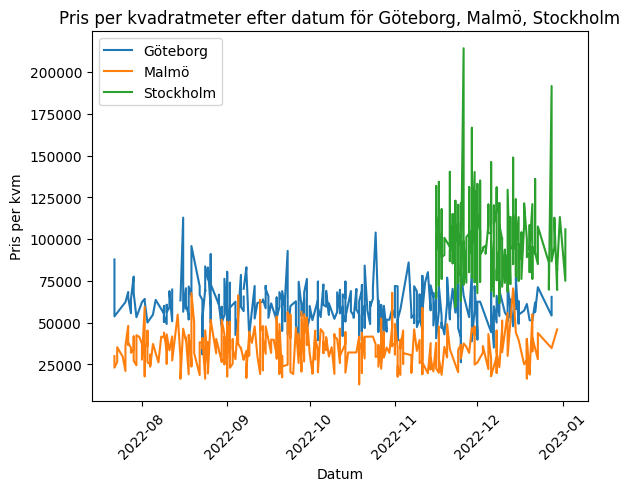

In [49]:
plt.plot(df_g["date"], df_g["psm"], label="Göteborg")
plt.plot(df_m["date"], df_m["psm"], label="Malmö")
plt.plot(df_s["date"], df_s["psm"], label="Stockholm")
plt.xlabel('Datum')
plt.ylabel('Pris per kvm')
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.title('Pris per kvadratmeter efter datum för Göteborg, Malmö, Stockholm')

## 2. Beskrivande statistik

#### Medelvärde

In [50]:
# Print the mean
print(f'\nMean of the data for each city:\n')
df.groupby("city").mean(numeric_only=True)


Mean of the data for each city:



,sm,price,psm,change
city,,,,
goteborg,58.267241,3.484152e+06,60243.582532,0.839943
malmo,54.574286,1.897010e+06,34582.219357,-1.282857
stockholm,51.257143,5.086397e+06,98957.804105,2.474286


#### Median

In [51]:
# Print the median
print(f'\nMedian of the data for each city:\n')
df.groupby("city").median(numeric_only=True)


Median of the data for each city:



,sm,price,psm,change
city,,,,
goteborg,57.0,3245000.0,59668.803419,0.0
malmo,54.0,1825000.0,33853.605121,0.0
stockholm,50.0,4672500.0,96470.205850,0.1


#### Max

In [52]:
# Print the max
print(f'\nMax values of the data for each city:\n')
df.groupby("city").max(numeric_only=True)


Max values of the data for each city:



,sm,price,psm,change
city,,,,
goteborg,164.0,9200000,112857.142857,21.5
malmo,84.0,5000000,70491.803279,19.1
stockholm,249.0,25900000,214285.714286,29.0


#### Min

In [53]:
# Print the min
print(f'\nMin values of the data for each city:\n')
df.groupby("city").min(numeric_only=True)


Min values of the data for each city:



,sm,price,psm,change
city,,,,
goteborg,26.0,1400000,26268.656716,-13.9
malmo,34.0,785000,13032.786885,-15.5
stockholm,30.0,2550000,59302.325581,-12.1


#### Standardavvikelse

In [54]:
# Print the stdDev
print(f'\nStandard Deviation of the data for each city:\n')
df.groupby("city").std(numeric_only=True)


Standard Deviation of the data for each city:



,sm,price,psm,change
city,,,,
goteborg,13.327200,9.641737e+05,11074.273909,5.551180
malmo,7.987377,6.906844e+05,10462.079026,4.833555
stockholm,15.867183,1.961338e+06,18040.684117,6.352512


#### Kvantiler

In [55]:
# Print the quantiles
print(f'\nQuantiles of the data for each class:\n')
df.groupby("city").quantile([0.05, 0.25, 0.50, 0.75, 0.95], numeric_only=True)


Quantiles of the data for each class:



sm      price            psm  change
city                                                   
goteborg  0.05  39.35  2443500.0   42675.781250  -7.130
          0.25  51.00  2861250.0   53101.371696  -2.300
          0.50  57.00  3245000.0   59668.803419   0.000
          0.75  64.00  3942500.0   66828.425481   3.200
          0.95  80.00  5165000.0   77809.523810  11.230
malmo     0.05  42.00   995000.0   19166.666667  -8.755
          0.25  49.25  1351250.0   26588.541667  -4.300
          0.50  54.00  1825000.0   33853.605121   0.000
          0.75  60.00  2250000.0   41566.964286   0.200
          0.95  67.00  3077500.0   52566.481590   7.500
stockholm 0.05  35.00  3200000.0   73812.406855  -5.510
          0.25  41.00  3878750.0   88405.186003  -1.300
          0.50  50.00  4672500.0   96470.205850   0.100
          0.75  59.00  6000000.0  107826.219512   5.400
          0.95  70.55  7850000.0  129314.516129  14.065

#### Korrelation

Om vi studerar tabellerna nedan så kan vi se ett visst samband mellan olika faktorer. Mellan antal kvadratmeter och slutpriset finns en svag positiv korrelation vilket tyder på att ju större lägenheten är ju dyrare blir den. Vi ser också att det finns en svag negativ korrelation mellan antal kvadratmeter och priset per kvadratmeter som visar att ju större lägenheten är så minskar priset per kvadratmeter.

Huruvida slutpriset går upp eller ner från det ursprungliga prisförslaget verkar ha en svag inverkan av storleken på lägenheten. Större lägenheter tenderar att sjunka i pris medan mindre lägenheter går upp. Högst korrelation ser vi som väntat mellan slutpris och pris per kvadratmeter där det finns en stark positiv korrelation.

In [56]:
# Show table of correlation
df.corr(numeric_only=True)

,sm,price,psm,change
sm,1.000000,0.462869,-0.112909,-0.064818
price,0.462869,1.000000,0.805059,0.211730
psm,-0.112909,0.805059,1.000000,0.302533
change,-0.064818,0.211730,0.302533,1.000000


<AxesSubplot: >

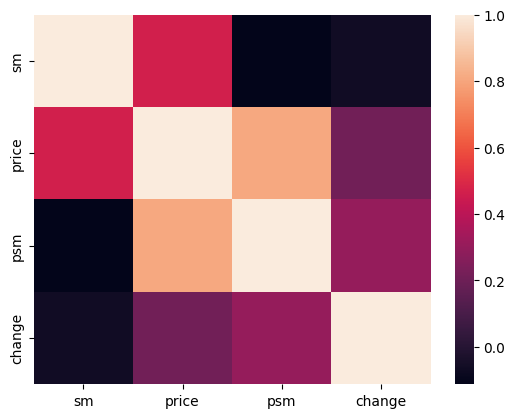

In [57]:
# Show heatmap of correlation
sns.heatmap(df.corr(numeric_only=True))

## 3. Beskrivande plottar

### Gemensam distribution

Figuren nedan visar en gemensam distribution grupperat per stad med antal kvadratmeter i X-axel och pris per kvadratmeter i Y-axel. Vad det gäller antal kvadratmeter så ser datan någorlunda lik ut för de olika städerna medan datan för pris per kvadratmeter visar sig tydligare i egna grupper med en mycket liten andel där alla städer överlappar. Priset per kvadratmeter rör sig mot en normalfördelning för alla städer.


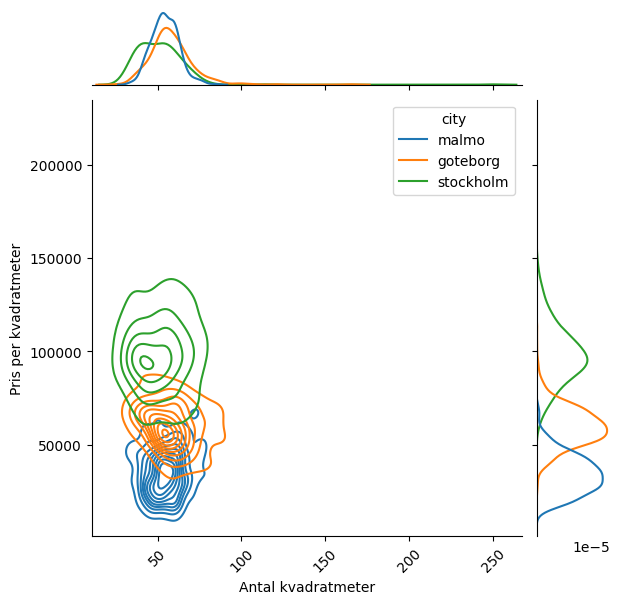

In [58]:
# Create a Joint Distribution
sns.jointplot(data=df, x="sm", y="psm", kind="kde", hue="city")
plt.xlabel('Antal kvadratmeter')
plt.ylabel('Pris per kvadratmeter')
plt.xticks(rotation=45)
plt.show()

### Lådogram

I figuren nedan ser vi ett lådogram med stad i X-axel och Pris per kvadratmeter i Y-led.

I detta diagram så är det enkelt att se outliers. Vi kan även konstatera att Stockholm har det största spannet i pris per kvadratmeter medan Malmö har det minsta. Ju mer priset per kvadratmeter ökar så ökar också spridningen av data, framförallt när det kommer till extremfall som vi ser i de outliers som ritas ut.

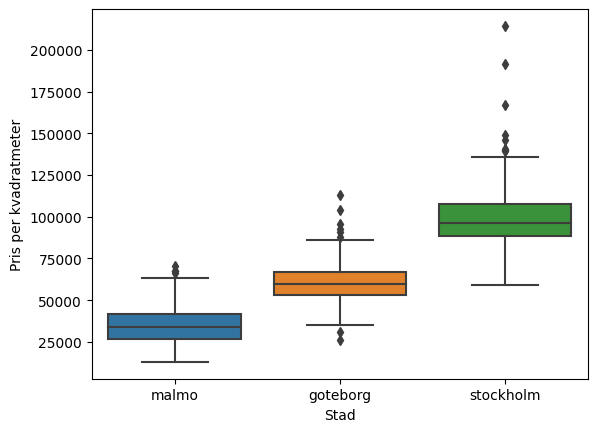

In [59]:
# Create a boxplot
sns.boxplot(x="city", y="psm", data=df)
plt.xlabel('Stad')
plt.ylabel('Pris per kvadratmeter')
plt.show()

## 4. Linjär regression

### Pair plot

Med en Pair plot i Seaborn får vi en översikt kring hur olika faktorer påverkar varandra. Med sina visuella grafer går det enklare att identifiera möjliga linjära regressioner. Vi går vidare i analysen med hur Pris per kvadratmeter påverkas av Slutpriset i Malmö.

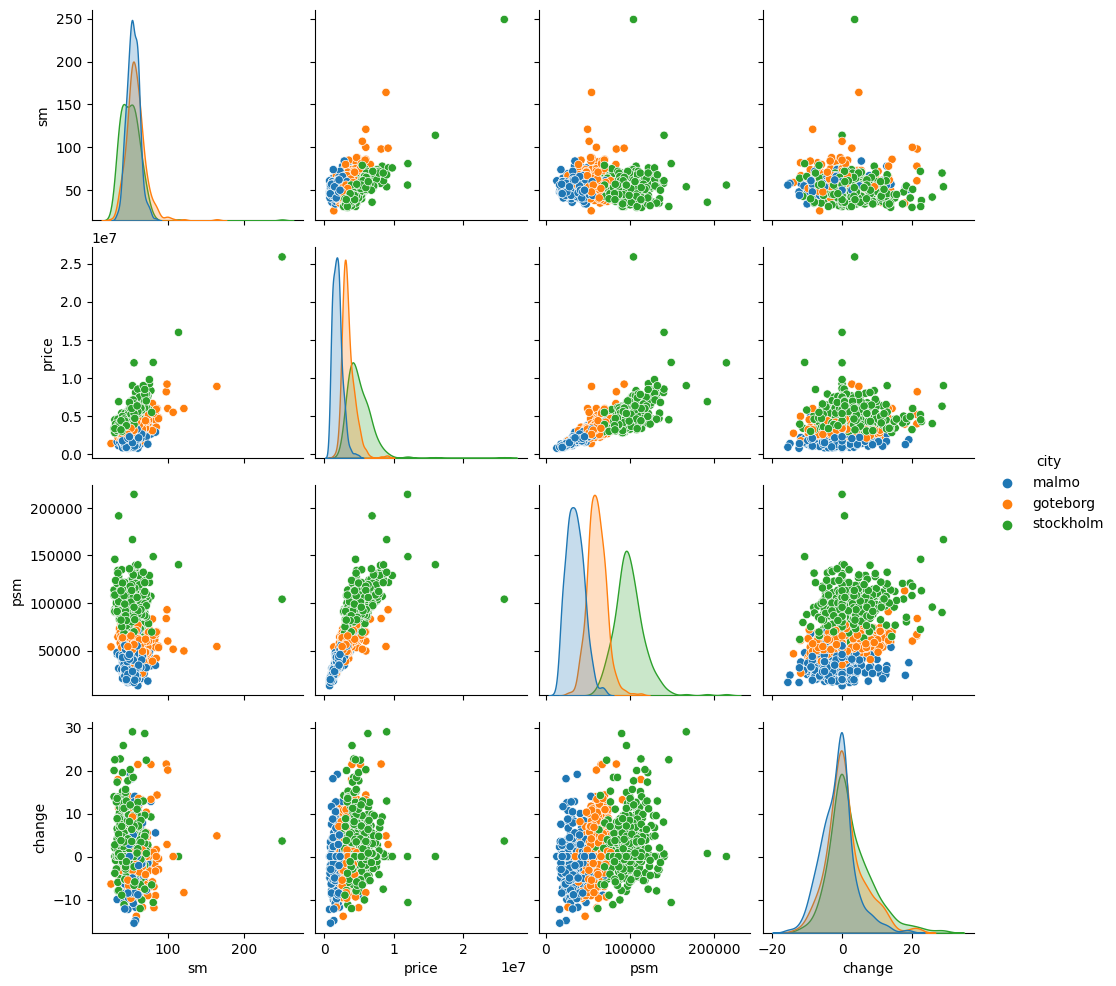

In [60]:
# Create a Pair plot
sns.pairplot(df, hue='city')

### Linjära regressionens ekvation och konfidensintervall

  Coefficient        Value        Lower         Upper
0           a  8853.929135  7418.402234  10289.456037
1           b     0.013563     0.012851      0.014274
Linear Equation: y = a + bx = 8853.929135123275 + 0.013562548568873402 * x


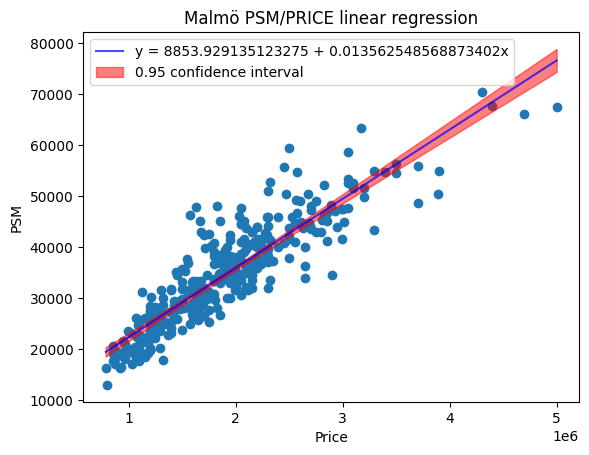

In [61]:
# Sort the data by X value
data = df_m.sort_values(by="price", ascending=True)

# Get calculated data from linear regression containing parameters and confidence interval
results = smf.ols('psm ~ price', data=data).fit()
conf_int = results.conf_int()

# Make prediction based on data from SMF.OLS
predictions = results.get_prediction(data).summary_frame(0.05)

# Print coefficient data
print(pd.DataFrame([
    {"Coefficient": "a", "Value": results.params[0], "Lower": conf_int[0][0], "Upper": conf_int[1][0]},
    {"Coefficient": "b", "Value": results.params[1], "Lower": conf_int[0][1], "Upper": conf_int[1][1]}
]))

# Print the linear equation
print(f'Linear Equation: y = a + bx = {results.params[0]} + {results.params[1]} * x')

# Plot data points
plt.scatter(data["price"], data["psm"])

# Plot linear regression
plt.plot(data["price"], results.params[0] + results.params[1] * data["price"], color="blue", alpha=0.7, label=f'y = {results.params[0]} + {results.params[1]}x')

# Plot confidence interval
plt.fill_between(data["price"], predictions["mean_ci_lower"], predictions["mean_ci_upper"], color="r", alpha=0.5, label="0.95 confidence interval")

# Set title, create the legend and show plot
plt.title("Malmö PSM/PRICE linear regression")
plt.legend()
plt.xlabel("Price")
plt.ylabel("PSM")
plt.show()

## 5. Transformerad data

### Logaritmera data för att hitta den bäst passande modellen för vår data

Nedan följer två olika transformationer av vår data. Bredvid den linjära regressionen ser vi också LOG-x och LOG-LOG.

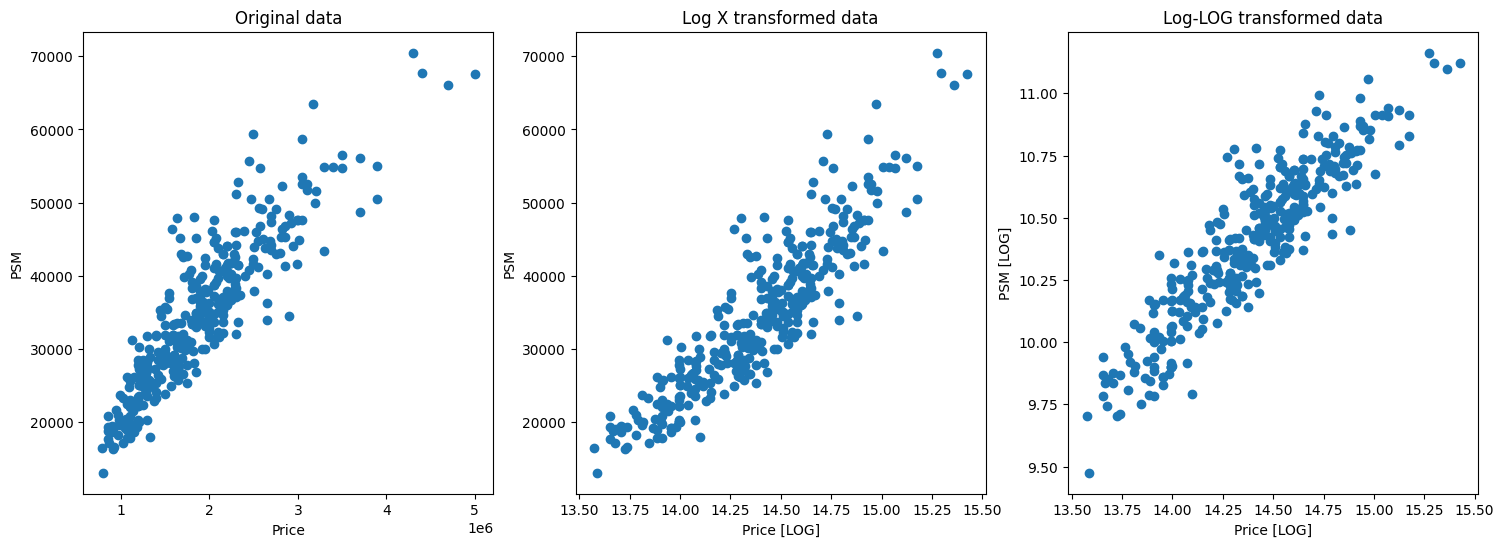

In [62]:
# Sort the data by X value
data = df_m.sort_values(by="price", ascending=True)
log_data = df_m.sort_values(by="price", ascending=True)

# Log transformation
log_data["price_log"] = np.log(log_data["price"])
log_data["psm_log"] = np.log(log_data["psm"])

# Show plots with original next to transformed data
plt.figure(figsize=(18,6))

# Original
plt.subplot(1, 3, 1)
plt.scatter(data['price'], data['psm'])
plt.title("Original data")
plt.xlabel("Price")
plt.ylabel("PSM")

# Transformed log
plt.subplot(1, 3, 2)
plt.scatter(log_data['price_log'], log_data['psm'])
plt.title("Log X transformed data")
plt.xlabel("Price [LOG]")
plt.ylabel("PSM")

# Transformed log-log
plt.subplot(1, 3, 3)
plt.scatter(log_data['price_log'], log_data['psm_log'])
plt.title("Log-LOG transformed data")
plt.xlabel("Price [LOG]")
plt.ylabel("PSM [LOG]")

plt.show()


### Linjär regression av logaritmerad data

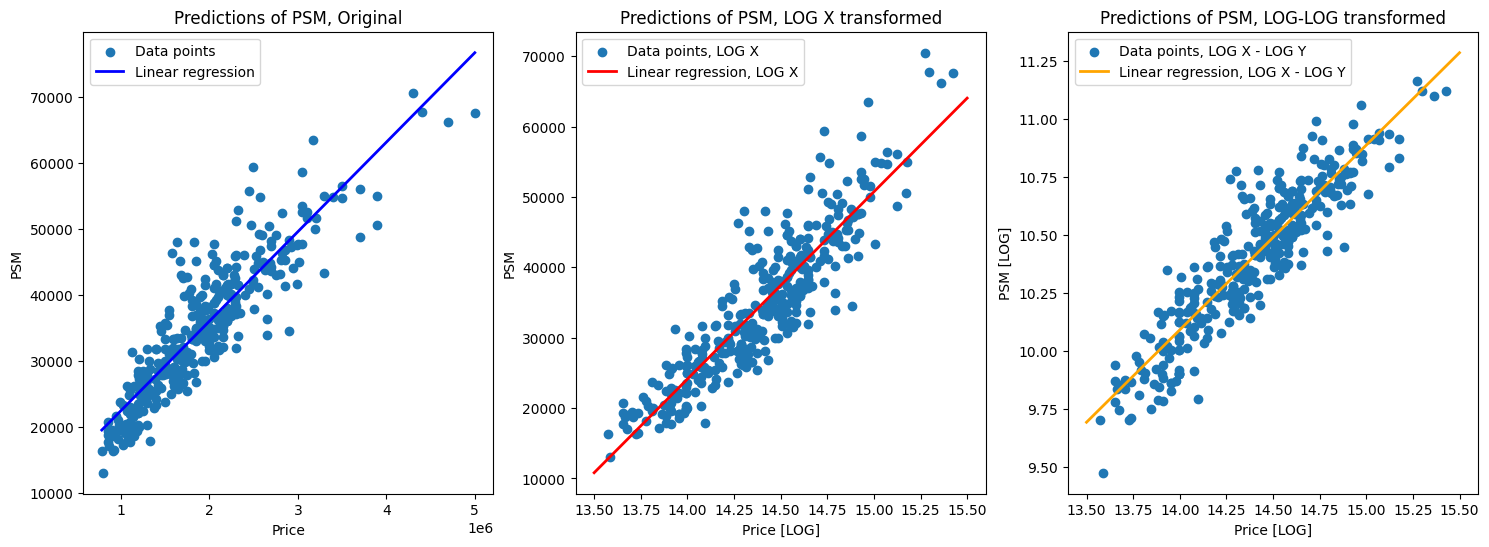

In [63]:
# Linear regression original data
model = LinearRegression().fit(data[["price"]], data["psm"])
pred = model.predict(data[["price"]])

# Linear regression LOG-X data
log_model = LinearRegression()
log_model.fit(log_data[['price_log']], log_data['psm'])
pred_log = log_model.predict(log_data[['price_log']])

# Linear regression LOG-LOG data
log_log_model = LinearRegression()
log_log_model.fit(log_data[['price_log']], log_data['psm_log'])
pred_log_log = log_log_model.predict(log_data[["price_log"]])

# Predict points
x_log = np.linspace(13.5, 15.5, 100)
y_log_log = log_log_model.predict(x_log.reshape(-1, 1))
draw_exp_model = log_model.predict(x_log.reshape(-1, 1))

plt.figure(figsize=(18,6))

# Plot original regression
plt.subplot(1,3,1)
plt.scatter(data["price"], data["psm"], label="Data points")
plt.plot(data["price"], results.params[0] + results.params[1] * data["price"], color="b", linewidth=2, label="Linear regression")
plt.legend()
plt.title("Predictions of PSM, Original")
plt.xlabel("Price")
plt.ylabel("PSM")

# Plot LOG X regression
plt.subplot(1,3,2)
plt.scatter(log_data['price_log'], log_data['psm'], label='Data points, LOG X')
plt.plot(x_log, draw_exp_model, label='Linear regression, LOG X', color='r', linewidth=2)
plt.legend()
plt.title("Predictions of PSM, LOG X transformed")
plt.xlabel("Price [LOG]")
plt.ylabel("PSM")

# Plot LOG-LOG regression
plt.subplot(1,3,3)
plt.scatter(log_data['price_log'], log_data['psm_log'], label='Data points, LOG X - LOG Y')
plt.plot(x_log, y_log_log, label='Linear regression, LOG X - LOG Y', color='orange', linewidth=2)
plt.legend()
plt.title("Predictions of PSM, LOG-LOG transformed")
plt.xlabel("Price [LOG]")
plt.ylabel("PSM [LOG]")

plt.show()


### Transformera tillbaka modellen och jämför mot ursprunglig regression

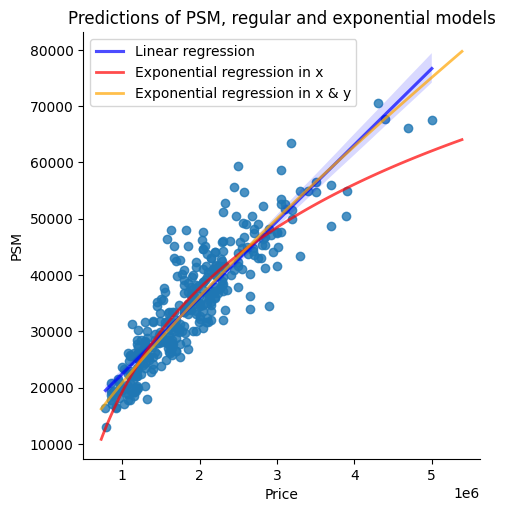

In [64]:
# plt.scatter(log_data['price'], log_data['psm'], label='Test data')
sns.lmplot(data=data, x="price", y="psm", line_kws={"color": "blue", "label": "Linear regression", "alpha": 0.7})
plt.plot(np.exp(x_log), draw_exp_model, label='Exponential regression in x', color='r', linewidth=2, alpha=0.7)
plt.plot(np.exp(x_log), np.exp(y_log_log), label='Exponential regression in x & y', color='orange', linewidth=2, alpha=0.7)
plt.legend()
plt.title("Predictions of PSM, regular and exponential models")
plt.xlabel("Price")
plt.ylabel("PSM")
plt.show()

## 6. Residualanalys

### Beräkna residualer, varians, standardavvikelse och R2

              Model  Residual variance  Standard deviation  R2 (R Squared)
0            Linear       2.176853e+07         4652.325795        0.800549
1     Exponential x       2.073000e+07         4539.994153        0.810065
2  Exponential x, y       2.097964e+07         4560.990344        0.807777


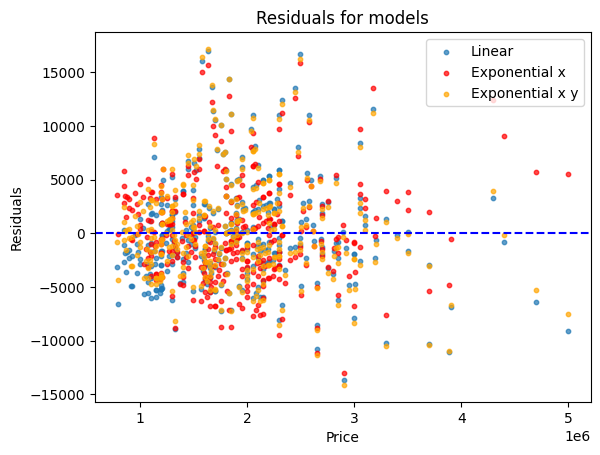

In [65]:
n = len(data)
k = 2

# Calculate Residuals
residual_linear = data["psm"] - pred
residual_exp_x = data["psm"] - pred_log
residual_exp_x_y = data["psm"] - np.exp(pred_log_log)

# Calculate Residual variance
residual_var_linear = np.sum((residual_linear)**2) / (n - k)
residual_var_exp_x = np.sum((residual_exp_x)**2) / (n - k)
residual_var_exp_x_y = np.sum((residual_exp_x_y)**2) / (n - k)

# Calculate Residual standard deviation
residual_std_linear = np.std(residual_linear)
residual_std_exp_x = np.std(residual_exp_x)
residual_std_exp_x_y = np.std(residual_exp_x_y)

# Calculate R squared
var_y = np.var(data['psm'])
r2_linear = 1 - residual_var_linear / var_y
r2_exp_x = 1 - residual_var_exp_x / var_y
r2_exp_x_y = 1 - residual_var_exp_x_y / var_y

# Format and print table of values
print(pd.DataFrame([
    {"Model": "Linear", "Residual variance": residual_var_linear, "Standard deviation": residual_std_linear, "R2 (R Squared)": r2_linear},
    {"Model": "Exponential x", "Residual variance": residual_var_exp_x, "Standard deviation": residual_std_exp_x, "R2 (R Squared)": r2_exp_x},
    {"Model": "Exponential x, y", "Residual variance": residual_var_exp_x_y, "Standard deviation": residual_std_exp_x_y, "R2 (R Squared)": r2_exp_x_y},
]))

# Visualize all residuals in a plot
plt.scatter(data["price"], residual_linear, alpha=0.7, s=10, label="Linear")
plt.scatter(data["price"], residual_exp_x, color="red", alpha=0.7, s=10, label="Exponential x")
plt.scatter(data["price"], residual_exp_x_y, color="orange", alpha=0.7, s=10, label="Exponential x y")
plt.axhline(0, color='blue', linestyle='--')
plt.title("Residuals for models")
plt.xlabel("Price")
plt.ylabel("Residuals")
plt.legend()
plt.show()






### Jämför modeller mot en normalfördelning

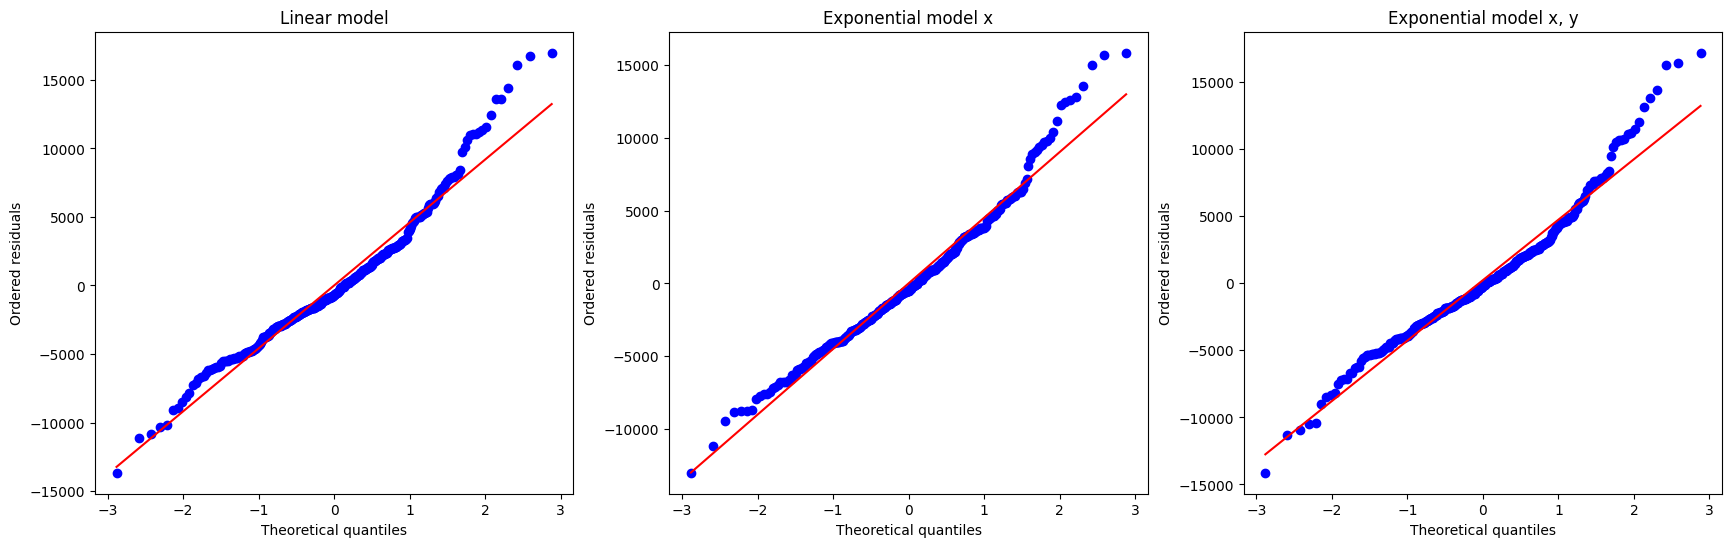

In [66]:
# Plot Q-Q figures
plt.figure(figsize=(21,6))

plt.subplot(1,3,1)
probplot(residual_linear, dist="norm", plot=plt)
plt.title("Linear model")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Ordered residuals")

plt.subplot(1,3,2)
probplot(residual_exp_x, dist="norm", plot=plt)
plt.title("Exponential model x")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Ordered residuals")

plt.subplot(1,3,3)
probplot(residual_exp_x_y, dist="norm", plot=plt)
plt.title("Exponential model x, y")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Ordered residuals")

plt.show()

### Vad visar diagrammen?

Den data som räknats ut ovan visar att alla modeller ligger rätt nära varandra när det kommer till hur väl de reflekterar den riktiga datan. Då axlarna innehåller väldigt stora tal där x-axeln går i miljoner och y-axeln i tio-tusental så blir residualvariansen extremt hög, för att istället få fram ett värde som enklare går att relatera till så har jag använt mig av residualernas standardavvikelse. Den exponentiella modellen i X har högst betyg och den minsta standardavvikelsen, följt av den exponentiella modellen i x och y som kommer strax bakom. Lägst betyg och högst standardavvikelse finner vi hos den Linjära modellen.

Alla modeller följer normalfördelningen rätt bra förutom mot slutet där värdena stegrar i väg en aning. Eftersom de olika modellerna ligger så nära i träffsäkerhet så får valet bero på syftet. Är det viktigaste att modellen har så små residualer som möjligt där även en differens på 0.01 har en stor inverkan så är Exponentiell i x den bästa modellen. Klarar vi oss med det något lägre R2-värdet mot att få en enklare modell så är definitivt den ej transformerade modellen aktuell.

## 7. Sammanfattning

I början av analysen kunde vi se en del diagram över hur bostadspriserna skiljer sig åt i Sveriges tre största städer. Ett tydligt resultat visar att prisnivån är som högst i Stockholm och faller sedan mot Göteborg och till sist Malmö. Det säljs också nästan fyra gånger fler lägenheter med två rum i Stockholm jämfört med Göteborg och Malmö som ligger väldigt jämnt. Dessa slutsatser kan dras om vi accepterar Booli's definition av innerstaden för respektive stad.

I den data som undersökts har vi endast tillgång till antal kvadratmeter och plats som fysiska koefficienter för vad slutpriset blir, i verkligheten finns det en uppsjö av olika faktorer som har en stark påverkan på ett slutpris. Bland dessa hittar vi skick, våning, utsikt, avgift och hur mycket andra bostäder som är till salu i närområdet. Men om vi låts anta att dessa faktorer är någorlunda normalfördelade över de olika städerna så kan vi definitivt se ett visst mönster mellan de datapunkter som vi har tillgång till.

Det är dyrast att bo i Stockholm medan Malmö är billigast. I alla städer så ser vi mönstret att priset per kvadratmeter sjunker något ju större lägenheten är. Medelstorleken på lägenheter som säljs ligger hyfsat nära varandra där, med avrundade värden, Göteborg ligger på 58kvm, Malmö 56kvm och Stockholm på 51kvm. Snittpriset hamnar på 99tkr/kvm i Stockholm, 60tkr/kvm i Göteborg och 35tkr/kvm i Malmö. Stockholm visar på en starkare budgivning där lägenheter i genomsnitt stiger från ursprungspriset med ~2,47%, Göteborg visar en stigning med ~0,8% och Malmö minskar då genomsnittet ligger på ~-1,28%.